In [1]:
import time as tm
import numpy as np

import matplotlib
matplotlib.rcParams['text.usetex'] = True

from scipy.special import comb
from scipy.misc import derivative
from scipy import integrate, interpolate

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.gridspec as gridspec
import utilities_simple as utilities
from chainconsumer import ChainConsumer

In [2]:
### Define all the constants 
c      = 299792.458           #km/s
GN     = 6.674e-11     #m^3/kg/s^2
Msolar = 1.989e30  # kg
Mpc    = 3.086e19     # km

cosmo_params = {
     'OmegaM' : 0.2999,
     'OmegaDE': 0.7,
     'OmegaR' : 1.e-4,
     'h'     : 0.7,
 }

#GW150914 parameters
m1   = 36       #solarmass
m2   = 29

Dl   = 410      #Mpc
zem  = 0.09

time = 2*365*24*3600    # time before merger in sec
tc   = 0
psic = 0

In [3]:
#Read in and interpolate LIGO and LISA PSDs.
ligo_asd    = np.genfromtxt('../data/lalsimulation_lib_LIGO-T1800545-v1-aLIGO_175Mpc.txt')
LISA_strain = np.loadtxt('../data/LISA_strain.txt')

ligo_interp = interpolate.interp1d(ligo_asd[:,0],ligo_asd[:,1])
lisa_interp = interpolate.interp1d(LISA_strain[:,0], LISA_strain[:,3])

In [4]:
def numerical_derivative(func, par, dx, conv=5e-2, factor=.5, verbose=False):
    
    ratio   = 1e8
    r_best  = 1e8
    dx_best = 0.
    
    while ratio > conv:
        d1    = derivative(func, par, dx=dx/2, order=5)
        d2    = derivative(func, par, dx=dx *2, order=5)
        
        ld1   = len(d1)
        prod  = d1 *d2
        
        d1    = d1[prod != 0]
        d2    = d2[prod != 0]
        
        r_vec = np.abs( (d1 -d2)/np.mean((d1, d2), axis=0) )
        
        if len(r_vec) < int(ld1/3):
            ratio = 1e6
        else:
            ratio = np.mean(r_vec)
        
        if ratio < r_best:
            dx_best = dx
            r_best  = ratio
        
        dx *= factor  
        
        if dx < 1e-15:
            #print(par, dx)
            #raise ValueError('No convergence')
            ratio = 1e-1 *conv
    
    print('Ratio best = %.2e for dx = %.2e' % (r_best, dx_best))
    return derivative(func, par, dx=dx_best, order=5)

Ratio best = 4.09e-02 for dx = 1.95e-03
[ 1.00000000e+00 -2.08764193e-07  4.98308436e-07  3.55311596e-07
 -1.41230329e-07 -3.54450171e-03 -1.48430489e-07  3.78631852e-07
  1.62832159e-07 -7.26039542e-08 -1.23667634e-04 -9.71441070e-08
  2.32874800e-07  6.39826918e-08 -3.12401408e-08 -1.17328119e-05
 -5.80412634e-08  7.44647312e-08  1.94597676e-08 -9.34902149e-09
 -1.42695424e-06 -3.10808661e-08 -8.45436579e-08  2.92319307e-09
 -6.40438425e-11 -1.48424216e-07 -1.44295629e-08 -2.33601537e-07
 -1.22174827e-09  2.21755301e-09 -1.01623219e-09 -5.47102973e-09
 -3.63773821e-07 -1.14500049e-09  1.59275015e-09  4.55016496e-09
 -1.50406041e-09 -4.67818115e-07 -4.11593166e-10  5.48955498e-10
  9.80583814e-10 -2.24229043e-10 -5.40250413e-07 -5.44466494e-11
  5.94189755e-11  4.44198597e-11 -6.78270994e-12 -5.77391117e-07
 -6.44434890e-13  4.87021424e-13  4.87793493e-13 -6.97267117e-13
 -5.77391121e-07 -6.78270994e-12  4.44079797e-11  5.94189755e-11
 -5.43722138e-11 -5.40250413e-07 -2.23970488e-10  

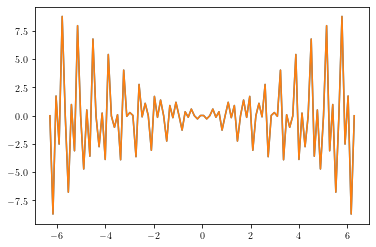

In [5]:
# Just a test of my function to compute derivatives
a_val    = 10
b_val    = 6
x        = np.linspace(-2 *np.pi, 2 * np.pi, 100)
my_func  = lambda a : np.sin(a * x)**b_val

analytic = b_val *x *np.cos(a_val *x) *np.sin(a_val * x)**(b_val -1)
dsin     = numerical_derivative(my_func, a_val, 1) 

plt.plot(x, dsin)
plt.plot(x, analytic)

print( (dsin -analytic ) / dsin )

In [37]:
# Define function to return covariance matrix for chosen waveform.

def Fisher_det(farr, pars, psd, cosmo_params, which_wf='GR', MG_flag=False, width=0, dist_corr=True):
    t0 = tm.perf_counter()
    if which_wf=='GR':
        waveform = utilities.waveform
    elif which_wf=='EFT':
        waveform = utilities.waveform_delta(cT_type='EFT').h_Delta_exact
    elif which_wf=='step':
        waveform = utilities.waveform_delta(cT_type='step', width=width).h_Delta_exact
    
    if dist_corr==False:
        hf = waveform(farr, pars, cosmo_params, dist_corr=False)
    else:      
        hf = waveform(farr, pars, cosmo_params)
    
    # Function to compute numerical derivatives w.r.t. lnM
    h_dlnMz_to_der = lambda lnMz_func: waveform(farr, 
                    [lnMz_func, pars[1], pars[2], pars[3], pars[4], pars[5], pars[6]], cosmo_params) / hf

    # Function to compute numerical derivatives w.r.t. lneta
    h_dlneta_to_der = lambda lneta_func: waveform(farr, 
                    [pars[0], lneta_func, pars[2], pars[3], pars[4], pars[5], pars[6]], cosmo_params) / hf
        
    # Function to compute numerical derivatives w.r.t. lnz
    h_dlnz_to_der = lambda lnz_func: waveform(farr, 
                    [pars[0], pars[1], lnz_func, pars[3], pars[4], pars[5], pars[6]], cosmo_params) / hf
    
    # Function to compute numerical derivatives w.r.t. lnz
    h_dc0_to_der = lambda c0_func: waveform(farr, 
                    [pars[0], pars[1], pars[2], pars[3], pars[4], c0_func, pars[6]], cosmo_params) / hf
    
    # Analytical derivetives w.r.t. tc and psic
    dh_dtc      = 2.j*np.pi*farr*waveform(farr, pars, cosmo_params)
    dh_dpsic    = -1.j*waveform(farr, pars, cosmo_params)
    
    to_der      = [h_dlnMz_to_der, h_dlneta_to_der, h_dlnz_to_der, dh_dtc, dh_dpsic, h_dc0_to_der]
    derivatives = []
    verbose     = False
    
    for i in range(0, len(to_der)):
        print('- Working on index', i)
        dx = np.abs(.1 *pars[i]) if pars[i] != 0 else 1e-1
        
        if i == 3 or i == 4:
            derivatives.append(to_der[i])
        elif i == 5:
            if MG_flag:
                derivatives.append(numerical_derivative(to_der[i], pars[i], dx=dx) * hf)
                
        else:
            if i == 1 or i ==2:
                dx = 1e-1
            elif i ==1:
                dx = 1e-5            
            derivatives.append(numerical_derivative(to_der[i], pars[i], dx=dx, verbose=verbose) *hf)
    
    print('Here I start computing fishers')
    derivatives   = derivatives[:2][::-1] + derivatives[2:]
    Fisher_matrix = np.zeros((len(derivatives),len(derivatives)))

    for i in range(0, len(derivatives)):
        for j in range(0,i +1):
            Fisher_matrix[i,j] = utilities.scalar_product(derivatives[i], derivatives[j], psd, farr)
            Fisher_matrix[j,i] = Fisher_matrix[i,j]
    
    print('This took %.2f seconds' % (tm.perf_counter() -t0) )
    connum = np.linalg.cond(Fisher_matrix)
    print('condition number (div by 1e15)',connum/1.e15)

    return derivatives, Fisher_matrix

In [7]:
# Get mass quantities
m_eff = m1*m2/(m1+m2)
Ms = m_eff**(3./5) * (m1+m2)**(2./5)     # source chirp mass in solarmass
eta = ((m1+m2)/Ms)**(-5./3)

Dl_s = Dl*Mpc/c        # Dl in sec

Ms_s = Ms * Msolar * GN / (c*1.e3)**3.       # source chirp mass in sec
Mtot_s = (m1+m2) * Msolar * GN / (c*1.e3)**3.

# Get frequency ranges for inspiral and plots
f_start = (5*Ms_s/256/time)**(3./8) / np.pi/Ms_s      # starting frequency at the time before merger
f_cut = utilities.get_freq(Mtot_s, eta, "cut")       # End of IMR template
fc = utilities.inspiral_fc(Mtot_s)
farr = np.logspace(np.log10(f_start),np.log10(fc),num=500)  #inspiral range only
f_plot = np.logspace(np.log10(f_start),np.log10(f_cut),num=500)     # full IMR waveform

Dl_arr = np.array([Dl_s]*len(farr))

In [8]:
print('eta',eta)
print('fc',fc)

eta 0.24710059171597634
fc 67.63181124855085


In [9]:
#Waveforms for inspiral and IMR, in GR
pars_GR = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 0, 0]

h_GR = utilities.waveform(farr, pars_GR, cosmo_params)
h_plot = utilities.waveform(f_plot, pars_GR, cosmo_params)

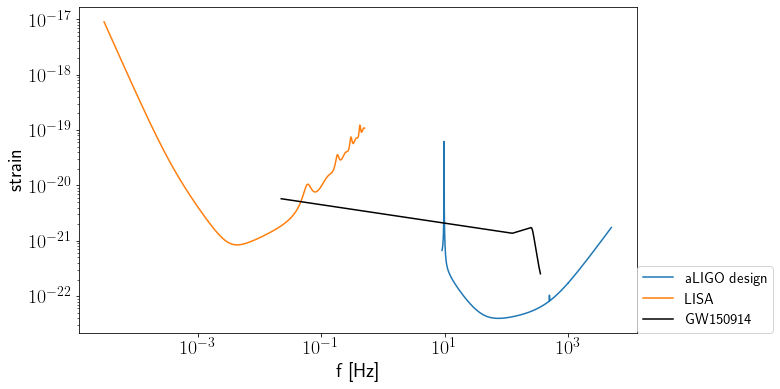

In [10]:
# Plot full IMR GR signal
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(f_plot, np.abs(f_plot*h_plot), color='k', label='GW150914')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15, loc=(1,0))

In [11]:
# Get waveform segments in LISA and LIGO ranges only.
farr_ligo = np.logspace(np.log10(ligo_asd[0,0]),np.log10(fc),num=500)
farr_lisa = np.logspace(np.log10(f_start),np.log10(LISA_strain[-1,0]),num=500)

ligo_psd = ligo_interp(farr_ligo)**2
lisa_psd = lisa_interp(farr_lisa)

h_GR_ligo = utilities.waveform(farr_ligo, pars_GR, cosmo_params)
h_GR_lisa = utilities.waveform(farr_lisa, pars_GR, cosmo_params)


In [12]:
# SNR in LISA and LIGO
SNR_ligo_sq = utilities.scalar_product(h_GR_ligo, h_GR_ligo, ligo_psd, farr_ligo)
SNR_ligo = np.sqrt(SNR_ligo_sq)

SNR_lisa_sq = utilities.scalar_product(h_GR_lisa, h_GR_lisa, lisa_psd, farr_lisa)
SNR_lisa = np.sqrt(SNR_lisa_sq)

print('design LIGO SNR')
print(SNR_ligo)
print('LISA SNR')
print(SNR_lisa)

design LIGO SNR
65.53220995174958
LISA SNR
3.4325121616962133


# GR Constraints

In [13]:
ders_ligo, fisher_ligo = Fisher_det(farr_ligo, pars_GR, ligo_psd, cosmo_params, which_wf='GR')
cov_matrix_ligo = np.linalg.inv(fisher_ligo)
pconstraints_ligo = np.sqrt(np.diag(cov_matrix_ligo))

print('LIGO GR constraints')
print(pconstraints_ligo)

- Working on index 0
Ratio best = 2.70e-02 for dx = 2.61e-03
- Working on index 1
Ratio best = 1.13e-02 for dx = 1.25e-02
- Working on index 2
Ratio best = 5.39e-05 for dx = 1.00e-01
- Working on index 3
- Working on index 4
- Working on index 5
Here I start computing fishers
This took 3.54 seconds
condition number (div by 1e15) 1.3743617518995846e-08
LIGO GR constraints
[0.01980816 0.00270017 0.01453587 0.00056515 0.20207629]


In [14]:
fisher_ligo

array([[ 3.37577738e+05, -1.59436142e+06, -8.70004002e-01,
         4.02207355e+06, -2.41272013e+04],
       [-1.59436142e+06,  8.02322806e+06, -3.80190989e+03,
        -1.42879125e+07,  9.55197074e+04],
       [-8.70004002e-01, -3.80190989e+03,  4.83626938e+03,
        -2.12511706e-11,  5.23935443e-14],
       [ 4.02207355e+06, -1.42879125e+07, -2.12511706e-11,
         3.33114490e+08, -1.13124342e+06],
       [-2.41272013e+04,  9.55197074e+04,  5.23935443e-14,
        -1.13124342e+06,  4.29447054e+03]])

In [15]:
ders_lisa, fisher_lisa = Fisher_det(farr_lisa, pars_GR, lisa_psd, cosmo_params, which_wf='GR') 
cov_matrix_lisa = np.linalg.inv(fisher_lisa)
pconstraints_lisa = np.sqrt(np.diag(cov_matrix_lisa))

print('LISA GR constraints')
print(pconstraints_lisa)

- Working on index 0
Ratio best = 5.26e-03 for dx = 7.95e-08
- Working on index 1
Ratio best = 2.23e-02 for dx = 7.81e-04
- Working on index 2
Ratio best = 5.39e-05 for dx = 1.00e-01
- Working on index 3
- Working on index 4
- Working on index 5
Here I start computing fishers
This took 8.00 seconds
condition number (div by 1e15) 6.743699910140831
LISA GR constraints
[3.35474898e-02 4.98386244e-06 2.74602282e-01 3.67868524e+00
 2.88910963e+00]


In [16]:
fisher_lisa

array([[ 7.76488461e+06,  5.64420375e+10, -2.51861997e+00,
        -1.54746821e+03,  8.82646509e+03],
       [ 5.64420375e+10,  4.10741727e+14, -1.08976075e+01,
        -1.16208175e+07,  6.50262393e+07],
       [-2.51861997e+00, -1.08976075e+01,  1.32685976e+01,
         1.05175451e-16, -5.85365313e-16],
       [-1.54746821e+03, -1.16208175e+07,  1.05175451e-16,
         6.95922276e-01, -2.49879922e+00],
       [ 8.82646509e+03,  6.50262393e+07, -5.85365313e-16,
        -2.49879922e+00,  1.17821397e+01]])

In [17]:
label_GR = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$']
fid_vals_GR = [0,0,0,0,0]

data_ligo = np.random.multivariate_normal(fid_vals_GR, cov_matrix_ligo, size=10000)
data_lisa = np.random.multivariate_normal(fid_vals_GR, cov_matrix_lisa, size=10000)

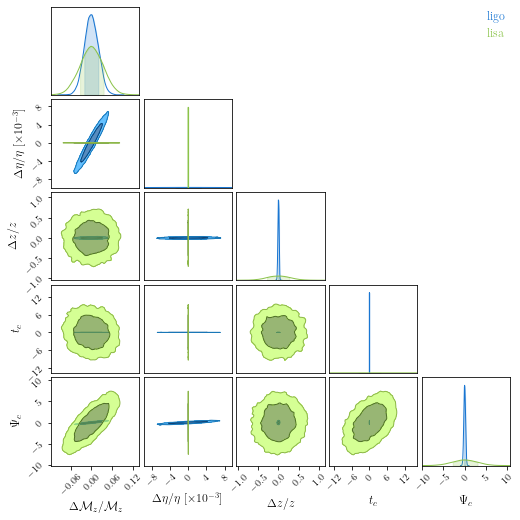

In [18]:
cc = ChainConsumer()
cc.add_chain(data_ligo, bins=30, smooth=True, parameters=label_GR, name='ligo');
cc.add_chain(data_lisa, bins=30, smooth=True, parameters=label_GR,name='lisa');
cc.plotter.plot();

# Step function

In [19]:
# Set parameters for step
fstar = 0.8
c0 = 0.9
w1 = 0.5

In [20]:
# Evaluate and plot Delta
cT_step_fo_w1 = utilities.cT_step(farr, fstar, c0, w1)
cT_step_fs_w1 = utilities.cT_step(farr*(1+zem), fstar, c0, w1)
Delta_step_w1 = 1-cT_step_fo_w1/cT_step_fs_w1

Text(0, 0.5, '$\\Delta$')

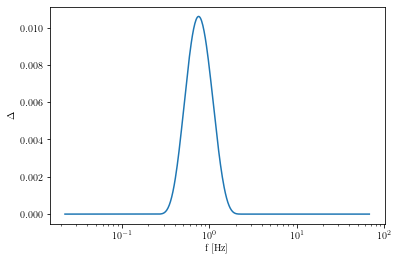

In [21]:
plt.semilogx(farr, Delta_step_w1)
plt.xlabel('f [Hz]')
plt.ylabel(r'$\Delta$')

In [28]:
# Set parameters for runs and evaluate
pars_step = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, c0, fstar]
pars_step_fid = [np.log(Ms), np.log(eta), np.log(zem), tc, psic, 1., fstar]

h_Delta_step_w1_ligo = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_ligo, pars_step, cosmo_params)
h_Delta_step_w1_fid_ligo = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_ligo, pars_step_fid, cosmo_params)

h_Delta_step_w1 = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step, cosmo_params)
h_Delta_step_w1_fid = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step_fid, cosmo_params)
h_Delta_step_w1_fid_nodist = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr_lisa, pars_step_fid, cosmo_params,dist_corr=False)

# For plotting only
h_Delta_step_w1_plot = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact(farr, pars_step, cosmo_params)

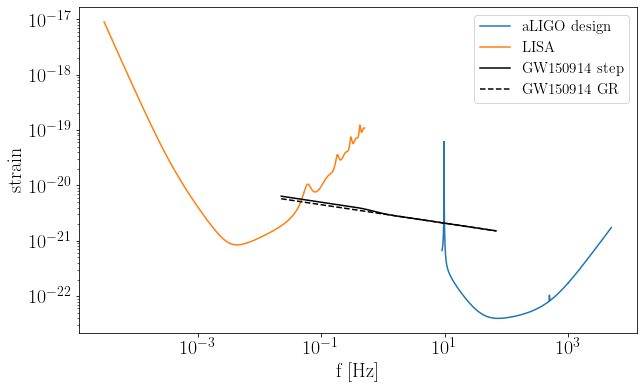

In [29]:
plt.figure(figsize=(10,6))
plt.loglog(ligo_asd[:,0],np.sqrt(ligo_asd[:,0])*ligo_asd[:,1],label='aLIGO design')
plt.loglog(LISA_strain[:,0],np.sqrt(LISA_strain[:,0]*LISA_strain[:,3]),label='LISA')
plt.loglog(farr, np.abs(farr*h_Delta_step_w1_plot), color='k', label='GW150914 step')
plt.loglog(farr, np.abs(farr*h_GR), color='k', label='GW150914 GR', linestyle='--')
plt.xlabel('f [Hz]', fontsize=20)
plt.ylabel('strain', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
# plt.savefig('../plots/amp_psd_step.pdf')

In [30]:
#mask_ligo = (farr>ligo_asd[0,0]) & (farr<=ligo_asd[-1,0])
#mask_lisa = (farr>LISA_strain[0,0]) & (farr<=LISA_strain[-1,0])

#ligo_psd = ligo_interp(farr[mask_ligo])**2
#lisa_psd = lisa_interp(farr[mask_lisa])

In [31]:
# SNR for fiducial and non-fiducial models
SNR_ligo_sq = utilities.scalar_product(h_Delta_step_w1_ligo, h_Delta_step_w1_ligo, ligo_psd, farr_ligo)
SNR_ligo_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid_ligo, h_Delta_step_w1_fid_ligo, ligo_psd, farr_ligo)
SNR_ligo_step = np.sqrt(SNR_ligo_sq)
SNR_ligo_step_fid = np.sqrt(SNR_ligo_sq_fid)

SNR_lisa_sq = utilities.scalar_product(h_Delta_step_w1, h_Delta_step_w1, lisa_psd, farr_lisa)
SNR_lisa_sq_fid = utilities.scalar_product(h_Delta_step_w1_fid, h_Delta_step_w1_fid, lisa_psd, farr_lisa)
SNR_lisa_step = np.sqrt(SNR_lisa_sq)
SNR_lisa_step_fid = np.sqrt(SNR_lisa_sq_fid)

print('LIGO SNR, mod and fiducial')
print(SNR_ligo_step,SNR_ligo_step_fid)
print('LISA SNR, mod and fiducial')
print(SNR_lisa_step,SNR_lisa_step_fid)

LIGO SNR, mod and fiducial
65.53220995174962 65.53220995174962
LISA SNR, mod and fiducial
3.8138995052846503 3.4325121616962155


In [38]:
# Constraints for fiducial and non-fiducial models
ders_lisa_step, fisher_lisa_step = Fisher_det(farr_lisa, pars_step, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=False)
cov_matrix_lisa_step = np.linalg.inv(fisher_lisa_step)

ders_lisa_step_distcorr, fisher_lisa_step_distcorr = Fisher_det(farr_lisa, pars_step, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=True)
cov_matrix_lisa_step_distcorr = np.linalg.inv(fisher_lisa_step_distcorr)

ders_lisa_step_fid, fisher_lisa_step_fid = Fisher_det(farr_lisa, pars_step_fid, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=True)
cov_matrix_lisa_step_fid = np.linalg.inv(fisher_lisa_step_fid)

ders_lisa_step_fid_distcorr, fisher_lisa_step_fid_distcorr = Fisher_det(farr_lisa, pars_step_fid, lisa_psd, cosmo_params, which_wf='step', MG_flag=True, width=w1, dist_corr=False)
cov_matrix_lisa_step_fid_distcorr = np.linalg.inv(fisher_lisa_step_fid_distcorr)

pconstraints_lisa_step = np.sqrt(np.diag(cov_matrix_lisa_step))
pconstraints_lisa_step_fid = np.sqrt(np.diag(cov_matrix_lisa_step_fid))
pconstraints_lisa_step_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_distcorr))
pconstraints_lisa_step_fid_distcorr = np.sqrt(np.diag(cov_matrix_lisa_step_fid_distcorr))

print('LISA step function')
print('mod')
print(pconstraints_lisa_step)
print('mod with distcorr')
print(pconstraints_lisa_step_distcorr)
print('fiducial')
print(pconstraints_lisa_step_fid)
print('fiducial with dist corr')
print(pconstraints_lisa_step_fid_distcorr)


- Working on index 0
Ratio best = 4.93e-02 for dx = 4.97e-09
- Working on index 1
Ratio best = 1.20e+00 for dx = 3.05e-06
- Working on index 2
Ratio best = 2.15e+00 for dx = 1.56e-03
- Working on index 3
- Working on index 4
- Working on index 5
Ratio best = 2.23e+00 for dx = 6.87e-07
Here I start computing fishers
This took 155.84 seconds
condition number (div by 1e15) 3.1196379476533376e+21
- Working on index 0
Ratio best = 4.93e-02 for dx = 4.97e-09
- Working on index 1
Ratio best = 1.20e+00 for dx = 3.05e-06
- Working on index 2
Ratio best = 2.15e+00 for dx = 1.56e-03
- Working on index 3
- Working on index 4
- Working on index 5
Ratio best = 2.23e+00 for dx = 6.87e-07
Here I start computing fishers
This took 162.18 seconds
condition number (div by 1e15) 2.0464008430301812e+21
- Working on index 0
Ratio best = 5.26e-03 for dx = 7.95e-08
- Working on index 1
Ratio best = 1.93e-02 for dx = 7.81e-04
- Working on index 2
Ratio best = 5.39e-05 for dx = 1.00e-01
- Working on index 3
- Wo

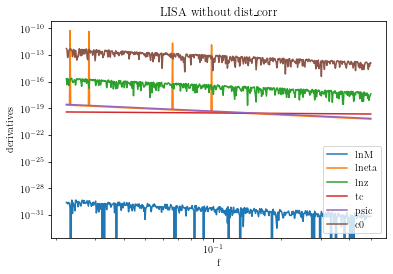

In [49]:
# plot derivatives
plt.figure()
plt.title('LISA without dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[4]),label='psic')
plt.loglog(farr_lisa, np.abs(ders_lisa_step[5]),label='c0')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()


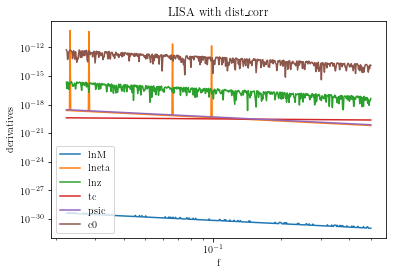

In [50]:
# plot derivatives
plt.figure()
plt.title('LISA with dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[4]),label='psic')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_distcorr[5]),label='c0')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()

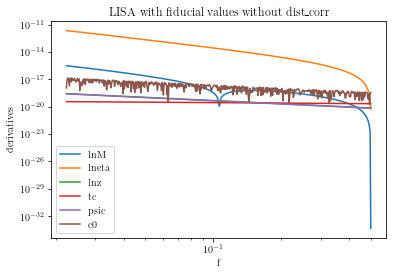

In [51]:
# plot derivatives
plt.figure()
plt.title('LISA with fiducial values without dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[4]),label='psic')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid[5]),label='c0')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()

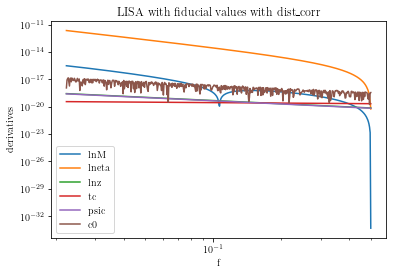

In [52]:
# plot derivatives
plt.figure()
plt.title('LISA with fiducial values with dist_corr')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[0]),label='lnM')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[1]),label='lneta')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[2]),label='lnz')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[3]),label='tc')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[4]),label='psic')
plt.loglog(farr_lisa, np.abs(ders_lisa_step_fid_distcorr[5]),label='c0')
plt.xlabel('f')
plt.ylabel('derivatives')
plt.legend()

In [41]:
wf = utilities.waveform_delta(cT_type='step', width=w1).h_Delta_exact

def to_der(par):
    ppars = np.array(pars_step)
    ppars[0] = par
    return wf(farr_lisa, ppars, cosmo_params, dist_corr=True)

dM = numerical_derivative(to_der, pars_step[0], 1e-1)

Ratio best = 4.93e-02 for dx = 5.96e-09


In [43]:
dM

array([-2.18372965e-19-9.72137298e-20j, -1.43982192e-19-1.88631169e-19j,
        2.34054908e-19-2.67977273e-20j, -1.46408617e-19+1.82382276e-19j,
       -1.45448556e-19+1.80980690e-19j, -2.29400070e-19-2.25126365e-20j,
        1.81246695e-11-4.53882899e-11j, -1.73348874e-19+1.46828926e-19j,
       -1.96307289e-19-1.11027644e-19j,  2.07903200e-19-8.31012636e-20j,
       -1.52809742e-19-1.61416291e-19j, -2.09312157e-19+6.98667295e-20j,
        1.05597710e-19+1.91935583e-19j,  6.69632563e-20-2.06914034e-19j,
        1.17489246e-19-1.81138393e-19j, -1.29067560e-19-1.71124512e-19j,
        3.31962755e-20-2.10183143e-19j, -2.07329395e-19-4.04962118e-20j,
        4.16369735e-20-2.05542448e-19j,  2.54654111e-20+2.06635070e-19j,
       -1.69476457e-19-1.18315856e-19j,  7.03258054e-20-1.92765632e-19j,
       -1.98207130e-19-4.70163874e-20j, -9.36589425e-20+1.79236380e-19j,
        1.44112323e-19+1.39782084e-19j,  1.10602047e-19-1.65809582e-19j,
        4.56098045e-20+1.92540912e-19j, -1.96345766

In [44]:
np.array(ders_lisa_step_distcorr)[0]

array([-3.57496298e-30-1.59147666e-30j, -2.35711866e-30-3.08806275e-30j,
        3.83169040e-30-4.38703017e-31j, -2.39684136e-30+2.98576269e-30j,
        3.17483249e-30-3.95042351e-30j, -3.75548652e-30-3.68552200e-31j,
       -2.71106821e-30+2.58536203e-30j, -2.83787789e-30+2.40372232e-30j,
       -3.21372786e-30-1.81762288e-30j, -4.53808457e-30+1.81392384e-30j,
       -2.50163350e-30-2.64253051e-30j, -3.42662939e-30+1.14378161e-30j,
        1.72873005e-30+3.14215909e-30j,  1.09624905e-30-3.38736977e-30j,
       -2.56454021e-30+3.95386560e-30j,  2.81727028e-30+3.73528405e-30j,
        5.43453046e-31-3.44088799e-30j, -3.39416970e-30-6.62959614e-31j,
        6.81634917e-31-3.36491564e-30j,  4.16891799e-31+3.38280299e-30j,
       -2.77448280e-30-1.93693754e-30j,  1.15129703e-30-3.15574777e-30j,
       -3.24483000e-30-7.69700756e-31j, -1.53328158e-30+2.93426165e-30j,
        2.35924906e-30+2.28835910e-30j,  1.81065542e-30-2.71445269e-30j,
        7.46673722e-31+3.15206888e-30j, -3.21435771

In [42]:
( dM -np.array(ders_lisa_step_distcorr)[0] ) / dM

array([1.-0.00000000e+00j, 1.-0.00000000e+00j, 1.+0.00000000e+00j,
       1.+0.00000000e+00j, 1.-8.08200482e-17j, 1.-0.00000000e+00j,
       1.-0.00000000e+00j, 1.-0.00000000e+00j, 1.-0.00000000e+00j,
       1.+0.00000000e+00j, 1.+7.86534634e-17j, 1.-0.00000000e+00j,
       1.+0.00000000e+00j, 1.-0.00000000e+00j, 1.-0.00000000e+00j,
       1.-0.00000000e+00j, 1.-2.79377918e-17j, 1.-2.79620533e-17j,
       1.-2.81270133e-17j, 1.+0.00000000e+00j, 1.+9.55035173e-17j,
       1.+5.51091328e-17j, 1.-0.00000000e+00j, 1.+0.00000000e+00j,
       1.+0.00000000e+00j, 1.-1.00482245e-16j, 1.-2.95976158e-17j,
       1.-0.00000000e+00j, 1.+0.00000000e+00j, 1.-1.54869121e-17j,
       1.-0.00000000e+00j, 1.+0.00000000e+00j, 1.-0.00000000e+00j,
       1.-0.00000000e+00j, 1.+0.00000000e+00j, 1.-0.00000000e+00j,
       1.-1.61877140e-17j, 1.+0.00000000e+00j, 1.+0.00000000e+00j,
       1.+3.21272278e-17j, 1.+0.00000000e+00j, 1.-8.47087561e-18j,
       1.+5.61720576e-17j, 1.-6.13845796e-17j, 1.+6.49189783e-

In [ ]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step_fid = np.linalg.inv(cov_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc = np.array(Fisher_matrix_lisa_step_fid)
Fisher_matrix_lisa_step_fid_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_fixtc)

In [ ]:
# Now fix tc to ms accuracy
Fisher_matrix_lisa_step = np.linalg.inv(cov_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc = np.array(Fisher_matrix_lisa_step)
Fisher_matrix_lisa_step_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fixtc)

In [ ]:
# Same for uncorrected version
Fisher_matrix_lisa_step_fid_distcorr = np.linalg.inv(cov_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc = np.array(Fisher_matrix_lisa_step_fid_distcorr)
Fisher_matrix_lisa_step_fid_distcorr_fixtc[3,3] = 1.e6
cov_matrix_lisa_step_fid_distcorr_fixtc = np.linalg.inv(Fisher_matrix_lisa_step_fid_distcorr_fixtc)

In [151]:
label = [r'$\Delta {\cal M}_z/{\cal M}_z$', r'$\Delta \eta/\eta$', r'$\Delta z/z$',r'$t_c$',r'$\Psi_c$', 'c0']
fid_vals = [0,0,0,0,0,1]
fid_vals_MG = [0,0,0,0,0,c0]

data = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid, size=20000)
data_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_fixtc, size=20000)
data_distcorr = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr, size=20000)
data_distcorr_fixtc = np.random.multivariate_normal(fid_vals, cov_matrix_lisa_step_fid_distcorr_fixtc, size=20000)
data_MG = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step, size=20000)
data_MG_fixtc = np.random.multivariate_normal(fid_vals_MG, cov_matrix_lisa_step_fixtc, size=20000)


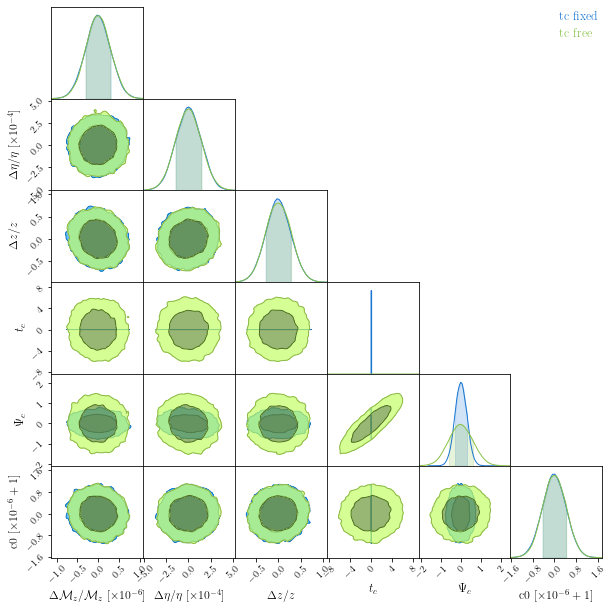

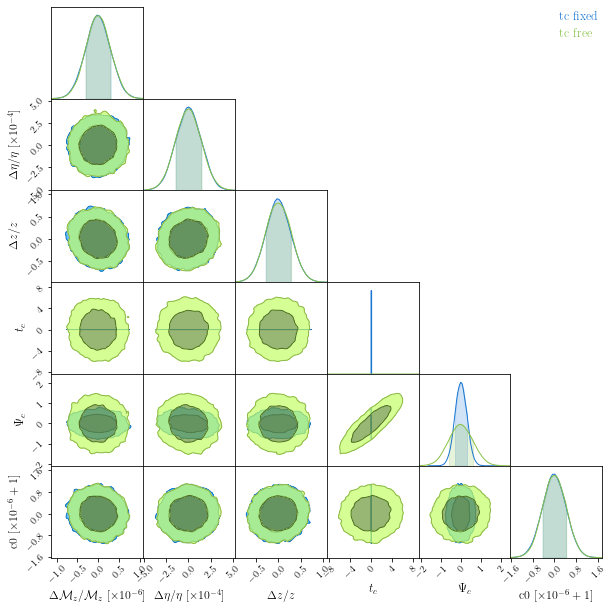

In [142]:
cc = ChainConsumer()
cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed');
cc.add_chain(data, bins=30, smooth=True, parameters=label, name='tc free');
cc.plotter.plot();


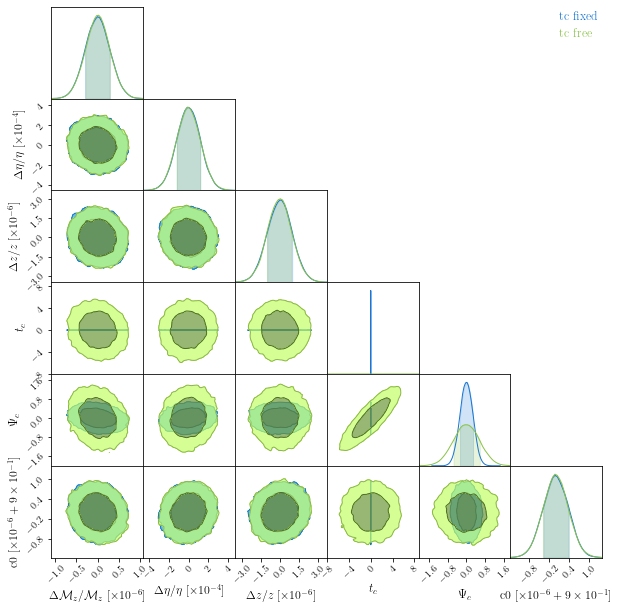

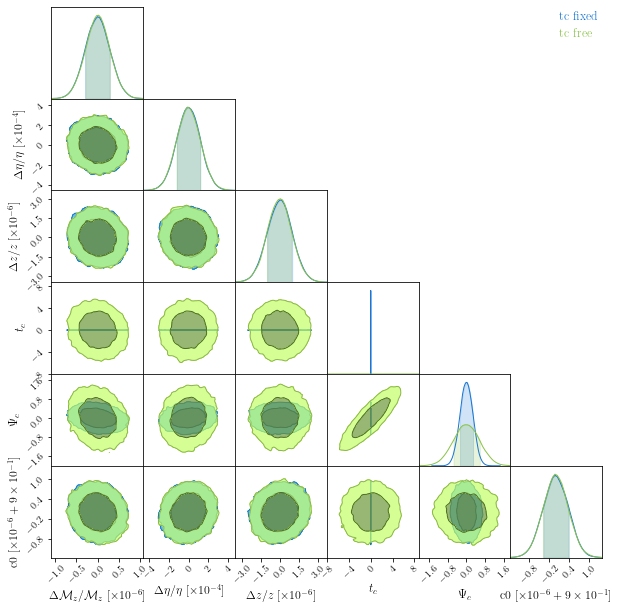

In [152]:
cc = ChainConsumer()
cc.add_chain(data_MG_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed');
cc.add_chain(data_MG, bins=30, smooth=True, parameters=label, name='tc free');
cc.plotter.plot();

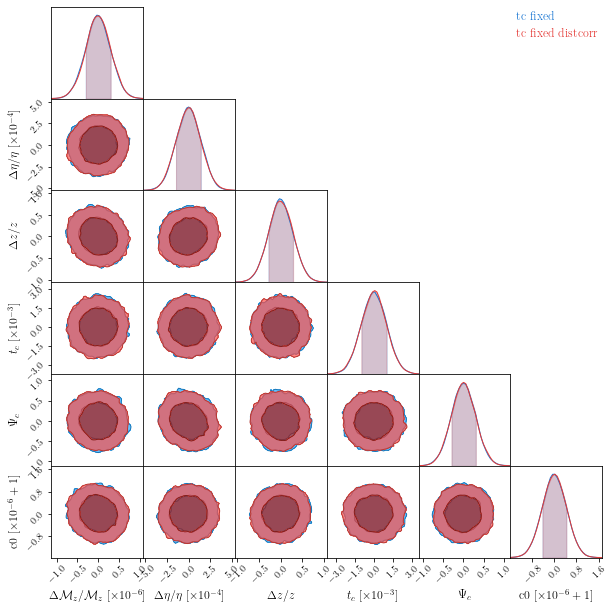

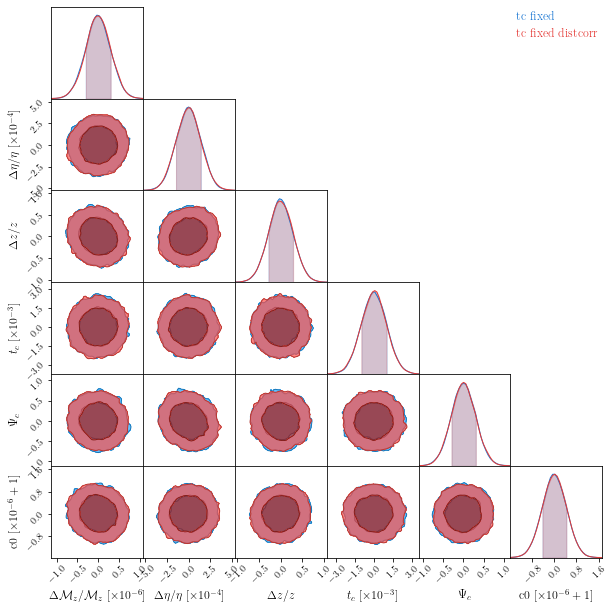

In [143]:
cc = ChainConsumer()

#cc.add_chain(data_fixtc, bins=30, smooth=True, parameters=label, name='tc fixed')
cc.add_chain(data_distcorr_fixtc, bins=30, smooth=True, parameters=label,name='tc fixed distcorr',color='r');
cc.plotter.plot();

In [144]:
Psi, Psi_old = utilities.Psi_Delta_exact(farr, fstar, c0, Ms, eta, zem, cosmo_params, tc, psic, cT_type='step', width=w1)

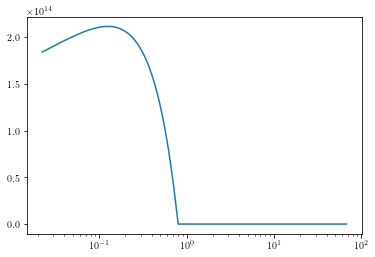

In [145]:
plt.semilogx(farr,abs(Psi/Psi_old))

In [127]:
cc.remove_chain('tc fixed')
cc.remove_chain('tc fixed distcorr')